<a href="https://colab.research.google.com/github/danielcdo/-MachineLearning/blob/main/asdLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression Model
Stastitical model to predict ASD

**Dataset source:** https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++

In [125]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.io import arff

%matplotlib inline

#Load dataset

In [87]:
# Load the data using "arff.loadarff" then convert it to a dataframe
# file location: /content/sample_data/Autism-Child-Data.arff
# Attribute-Relation File Format (ARFF)
data = arff.loadarff('sample_data/Autism-Child-Data.arff',  )
df = pd.DataFrame(data[0])

In [88]:
# dataset contains b's:python's way of displaying a bytes array and are not part of the data
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',6.0,b'm',b'Others',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
1,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',6.0,b'm',b'Middle Eastern ',b'no',b'no',b'Jordan',b'no',5.0,b'4-11 years',b'Parent',b'NO'
2,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'0',b'0',6.0,b'm',b'?',b'no',b'no',b'Jordan',b'yes',5.0,b'4-11 years',b'?',b'NO'
3,b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',5.0,b'f',b'?',b'yes',b'no',b'Jordan',b'no',4.0,b'4-11 years',b'?',b'NO'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',5.0,b'm',b'Others',b'yes',b'no',b'United States',b'no',10.0,b'4-11 years',b'Parent',b'YES'


#Data cleanup

 - remove the 'bytes' from object columns - string
 - unstack and add the 'age' column back - only good column

In [89]:
#df['A1_Score'] = df['A1_Score'].str.decode('utf-8')
# select only string columns
df_str = df.select_dtypes([np.object])

In [90]:
# decode to remove 'bs'
df_tr = df_str.stack().str.decode('utf-8').unstack()

In [91]:
df_tr['age'] = df['age']  # dataframe transformed

In [92]:
df_tr.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,relation,Class/ASD,age
0,1,1,0,0,1,1,0,1,0,0,m,Others,no,no,Jordan,no,4-11 years,Parent,NO,6.0
1,1,1,0,0,1,1,0,1,0,0,m,Middle Eastern,no,no,Jordan,no,4-11 years,Parent,NO,6.0
2,1,1,0,0,0,1,1,1,0,0,m,?,no,no,Jordan,yes,4-11 years,?,NO,6.0
3,0,1,0,0,1,1,0,0,0,1,f,?,yes,no,Jordan,no,4-11 years,?,NO,5.0
4,1,1,1,1,1,1,1,1,1,1,m,Others,yes,no,United States,no,4-11 years,Parent,YES,5.0


In [93]:
df_tr.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender', 'ethnicity',
       'jundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc',
       'relation', 'Class/ASD', 'age'],
      dtype='object')

In [94]:
# re-arrange columns
data = df_tr[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender', 'age','ethnicity',
       'jundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc',
       'relation', 'Class/ASD']]

In [76]:
data.head(5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,age,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,m,6.0,Others,no,no,Jordan,no,4-11 years,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,m,6.0,Middle Eastern,no,no,Jordan,no,4-11 years,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,m,6.0,?,no,no,Jordan,yes,4-11 years,?,NO
3,0,1,0,0,1,1,0,0,0,1,f,5.0,?,yes,no,Jordan,no,4-11 years,?,NO
4,1,1,1,1,1,1,1,1,1,1,m,5.0,Others,yes,no,United States,no,4-11 years,Parent,YES


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 291
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         292 non-null    object 
 1   A2_Score         292 non-null    object 
 2   A3_Score         292 non-null    object 
 3   A4_Score         292 non-null    object 
 4   A5_Score         292 non-null    object 
 5   A6_Score         292 non-null    object 
 6   A7_Score         292 non-null    object 
 7   A8_Score         292 non-null    object 
 8   A9_Score         292 non-null    object 
 9   A10_Score        292 non-null    object 
 10  gender           292 non-null    object 
 11  age              288 non-null    float64
 12  ethnicity        292 non-null    object 
 13  jundice          292 non-null    object 
 14  austim           292 non-null    object 
 15  contry_of_res    292 non-null    object 
 16  used_app_before  292 non-null    object 
 17  age_desc        

In [96]:
data.isnull().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
gender             0
age                4
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
age_desc           0
relation           0
Class/ASD          0
dtype: int64

Columns to number object: apply(pd.to_numeric)

In [97]:
# transform A#_Score columns to number
data[['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score','A10_Score']] = data[['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score','A10_Score']].apply(pd.to_numeric)

In [118]:
print(data.dtypes)

A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
gender              object
age                float64
ethnicity           object
jundice             object
austim              object
contry_of_res       object
used_app_before     object
age_desc            object
relation            object
Class/ASD           object
dtype: object


##Exploratory Data Analysis - EDA

In [119]:
data.describe()
#data.tail()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,288.000000
mean,0.633562,0.534247,0.743151,0.551370,0.743151,0.712329,0.606164,0.496575,0.493151,0.726027,6.354167
std,0.482658,0.499682,0.437646,0.498208,0.437646,0.453454,0.489438,0.500847,0.500811,0.446761,2.365456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


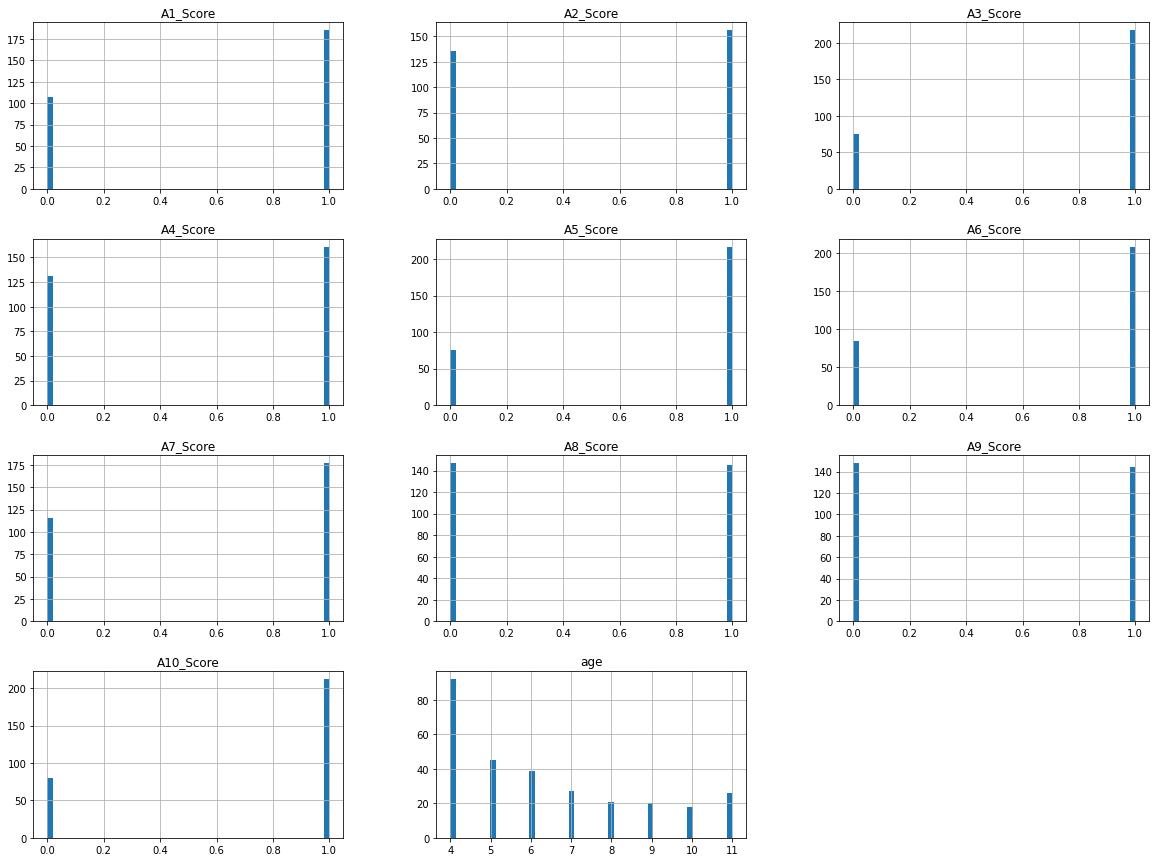

In [100]:
# call hist method
data.hist(bins=50, figsize=(20,15));

# More EAD using seaborn

**Histogram of the age**

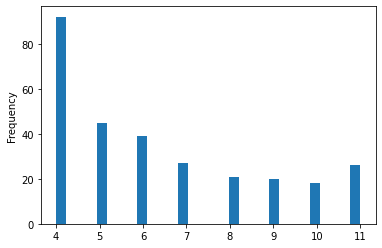

In [178]:
data['age'].plot.hist(bins=30);

#Categorical scatterplots showing ASD versus Age

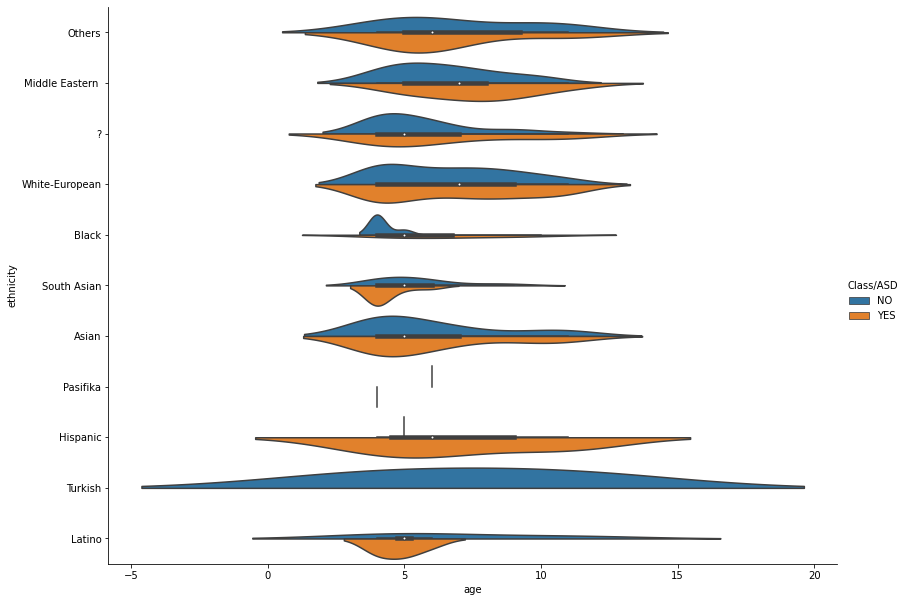

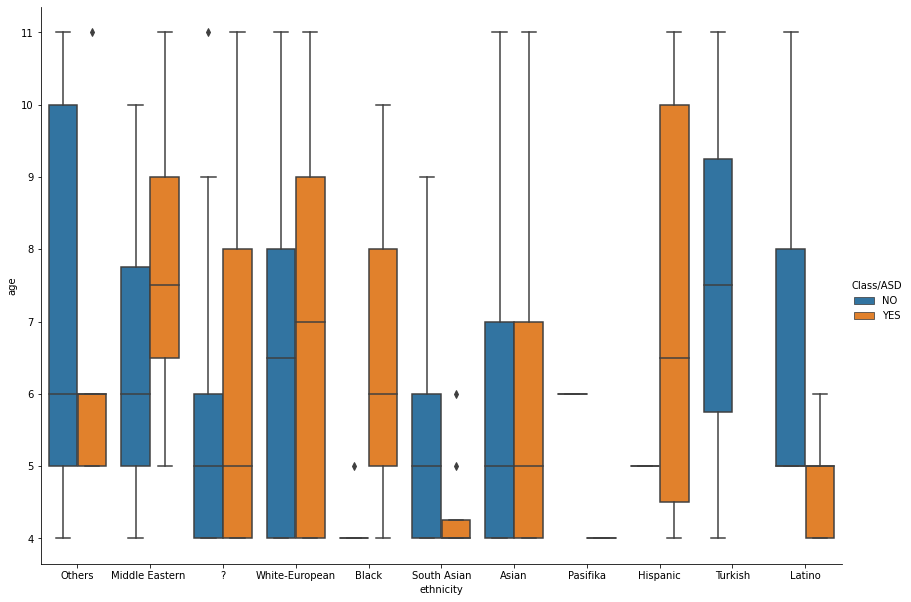

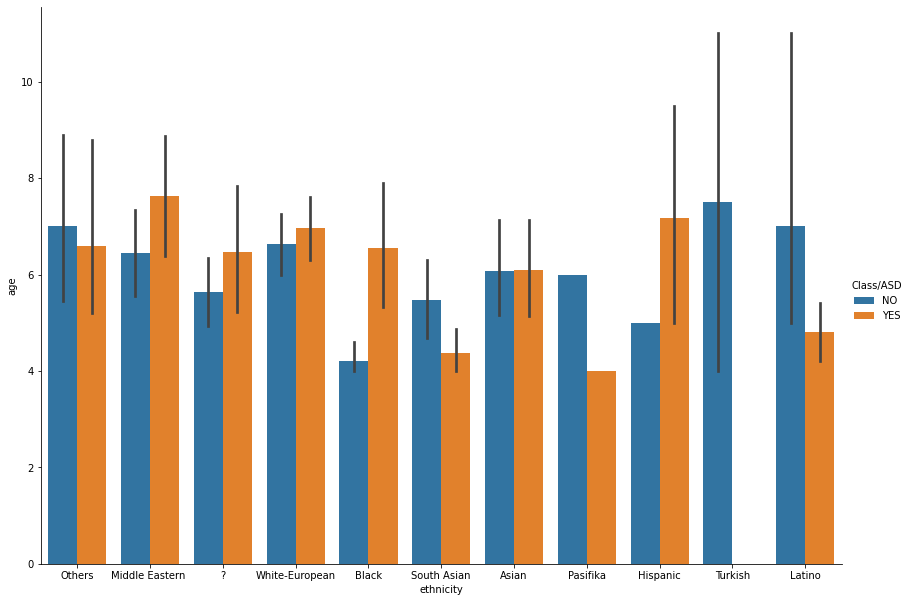

In [182]:
# contry_of_res

sns.catplot(x="age", y="ethnicity", hue="Class/ASD", kind="violin", split=True, data=data, height=8.27, aspect=11.7/8.27);
sns.catplot(x="ethnicity", y="age", hue="Class/ASD", kind="box", data=data, height=8.27, aspect=11.7/8.27);
sns.catplot(x="ethnicity", y="age", hue="Class/ASD", kind="bar", data=data, height=8.27, aspect=11.7/8.27);


# Check data correlation

In [101]:
# correlation among every pair of the features using person method.
# Pearson method is the standard correlation coefficient available in Pandas.
data.corr(method='pearson')

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age
A1_Score,1.000000,0.030840,0.073486,0.271476,0.154828,0.113350,0.027051,0.058761,0.153071,0.106534,0.101390
A2_Score,0.030840,1.000000,0.111075,0.124046,-0.046066,0.134627,0.020211,0.021067,0.083334,0.072961,-0.045817
A3_Score,0.073486,0.111075,1.000000,0.273490,0.138802,0.232463,0.007417,0.191943,0.250645,0.148550,-0.140640
A4_Score,0.271476,0.124046,0.273490,1.000000,0.115884,0.354650,0.019836,0.289916,0.338849,0.125205,0.170580
A5_Score,0.154828,-0.046066,0.138802,0.115884,1.000000,0.180515,0.183891,0.144910,0.078179,0.254003,-0.069615
A6_Score,0.113350,0.134627,0.232463,0.354650,0.180515,1.000000,-0.047724,0.298268,0.278804,0.254210,0.043490
A7_Score,0.027051,0.020211,0.007417,0.019836,0.183891,-0.047724,1.000000,0.155693,0.220280,0.039182,0.123534
A8_Score,0.058761,0.021067,0.191943,0.289916,0.144910,0.298268,0.155693,1.000000,0.212260,0.149370,0.052083
A9_Score,0.153071,0.083334,0.250645,0.338849,0.078179,0.278804,0.220280,0.212260,1.000000,0.191249,0.092211
A10_Score,0.106534,0.072961,0.148550,0.125205,0.254003,0.254210,0.039182,0.149370,0.191249,1.000000,0.035157


In [102]:
# call pandas scatter_matrix
#scatter_matrix(data, figsize=(12,8));
data.head(5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,age,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,m,6.0,Others,no,no,Jordan,no,4-11 years,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,m,6.0,Middle Eastern,no,no,Jordan,no,4-11 years,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,m,6.0,?,no,no,Jordan,yes,4-11 years,?,NO
3,0,1,0,0,1,1,0,0,0,1,f,5.0,?,yes,no,Jordan,no,4-11 years,?,NO
4,1,1,1,1,1,1,1,1,1,1,m,5.0,Others,yes,no,United States,no,4-11 years,Parent,YES


#Preprocessing - data cleansing

Data to be load in the ML model.
Build a pipeline to deal with missing values, scalling, and transform string values to numeric.

In [103]:
# X features, attributes columns
X = data.drop("Class/ASD", axis=1)

# y labels/targets
y = data["Class/ASD"].copy()

print('Features shape: ', len(X))
print('Labels shape: ', len(y))

Features shape:  292
Labels shape:  292


# Build a pipeline

- missing data using SimpleImputer
- OneHotEncode to categorical attributes
- StandandScaler

In [104]:
# testing with 2 features only
#num_features = X[['A1_Score',	'A2_Score']]

# get all numeric attributes
num_features = X.select_dtypes(include=[np.number])

In [105]:
num_features

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age
0,1,1,0,0,1,1,0,1,0,0,6.0
1,1,1,0,0,1,1,0,1,0,0,6.0
2,1,1,0,0,0,1,1,1,0,0,6.0
3,0,1,0,0,1,1,0,0,0,1,5.0
4,1,1,1,1,1,1,1,1,1,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1,7.0
288,1,0,0,0,1,0,1,0,0,1,7.0
289,1,0,1,1,1,1,1,0,0,1,4.0
290,1,1,1,0,1,1,1,1,1,1,4.0


In [107]:
# IMPORT: numberical features as a list. If not, for some situations the Fit_Tansform will not work 
num_features = list(num_features)

# pipeline for numerical attributes
num_pipeline = Pipeline(steps=[
                               ('imputer',  SimpleImputer(strategy='median')),
                               ('std_scale', StandardScaler())])

# categorical_features=['gender','age','ethnicity','jundice','austim']
# categorical_features=['gender']
#categorical_features= ['test']

# get string features
categorical_features = list(X.columns[X.dtypes == 'object'])          # set features parameters as a list

#full pipeline using ColumnTransformer - deal with numerical and categorical features once
full_pipeline=ColumnTransformer(transformers=[
                                              ('num', num_pipeline, num_features),
                                              ('categorical', OneHotEncoder(), categorical_features)])

In [43]:
# TODO:
# Use the ColumnTransformer to apply the transformations to the correct columns in the dataframe.
# integer_features = list(X.columns[X.dtypes == 'int64'])


In [108]:
# fit and transformer full_pipeline
# transformed data
X_transformed = full_pipeline.fit_transform(X)

In [109]:
print('Type for the data transformded after applying full pipeline :', type(X_transformed))

Type for the data transformded after applying full pipeline : <class 'scipy.sparse.csr.csr_matrix'>


# Apply a Machine Learning Method


# Splitting the datasest transformed in **Train** and **Test**

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Fit and train the dataset

In [111]:
# fit a logistic regression model
clf_logr = LogisticRegression()   # defined an object

clf_logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
print('Logistic Regression model fitted against training dataset already preprocessing.')

Logistic Regression model fitted against training dataset already preprocessing.


# Predicting against test dataset

In [113]:
acd_predictions = clf_logr.predict(X_test)

# Model Metrics

In [114]:
print('Classification Report:')
print(classification_report(y_test, acd_predictions))

Classification Report:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00        51
         YES       1.00      1.00      1.00        37

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



In [115]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, acd_predictions))

Confusion Matrix:
[[51  0]
 [ 0 37]]


# The model seems to generalize very well!
However, it needs a further investigation.
**Overfitting** seems to be present!